In [184]:
import numpy as np
from numba import njit
import gillespy2
from gillespy2 import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2 import EventAssignment, EventTrigger, Event
import torch 
import matplotlib.pyplot as plt

Matrix elements: $D_a, D_a', D_r, D_r', M_r, M_a, A, R, C, \emptyset$

In [ ]:
### Set up the S-matrices for the 5 sets of reactions

parameters: 
$\alpha_a, \alpha_a', \alpha_r, \alpha_r, \gamma_a, 
\beta_a, \beta_r, \gamma_a, \gamma_r, \gamma_c,
\delta_a, \delta_r, \delta_{mr}, \delta_{ma},
\theta_a, \theta_r$

In [ ]:
### Set up the corresponding P-vector

In [ ]:
# Recognize the initial condition

In [458]:
class Lotkavolterra_Oscillator(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Circadium rythm")
        self.volume = 1

        # Define the parameters of the system
        self.add_parameter(Parameter(name="alpha", expression=1))     # Initial value: 1
        self.add_parameter(Parameter(name="beta", expression=0.005))  # Initial value: 0.005  
        self.add_parameter(Parameter(name="gamma", expression=0.6))   # Initial value: 0.6

        # Add species and define the initial condition (count or concentration) of each species
        self.add_species(Species(name="R", initial_value=100, mode="discrete"))    # Initial value: 100
        self.add_species(Species(name="F", initial_value=50, mode="discrete"))     # Initial value: 50

        # Reactions
        self.add_reaction(Reaction(name="r1", reactants={'R': 1}, products={'R': 2}, rate=self.listOfParameters["alpha"]))
        self.add_reaction(Reaction(name="r2", reactants={'R': 1, 'F': 1}, products={'F': 2}, rate=self.listOfParameters["beta"]))
        self.add_reaction(Reaction(name="r3", reactants={'F': 1}, products={}, rate=self.listOfParameters["gamma"]))

        # Timespan
        self.timespan(np.linspace(0, 30, 301))

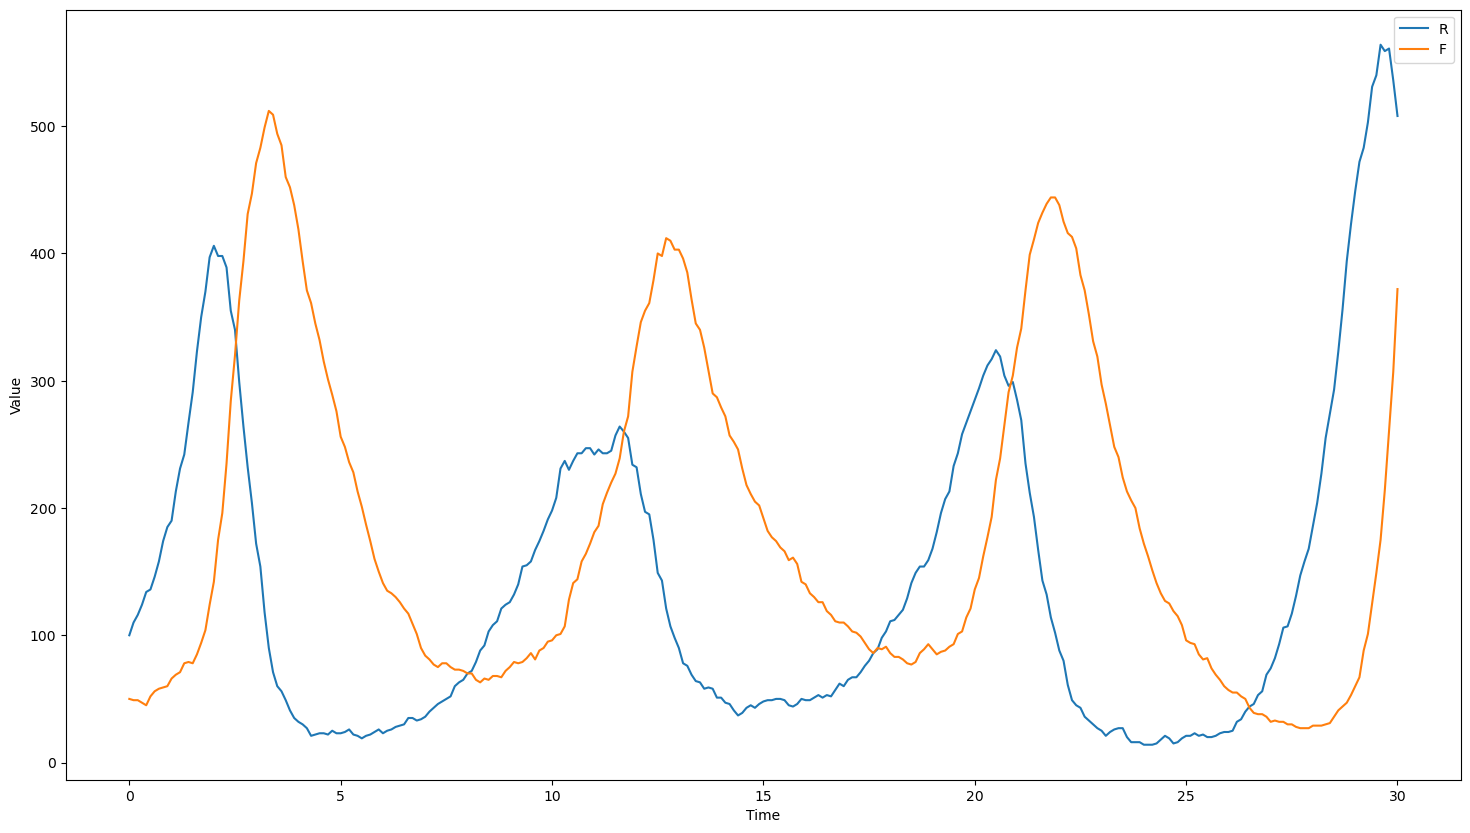

In [459]:
model = Lotkavolterra_Oscillator()
result = model.run(algorithm="SSA", number_of_trajectories=1)
result.plot()

# Custom SSA 
This is just for understanding the code above

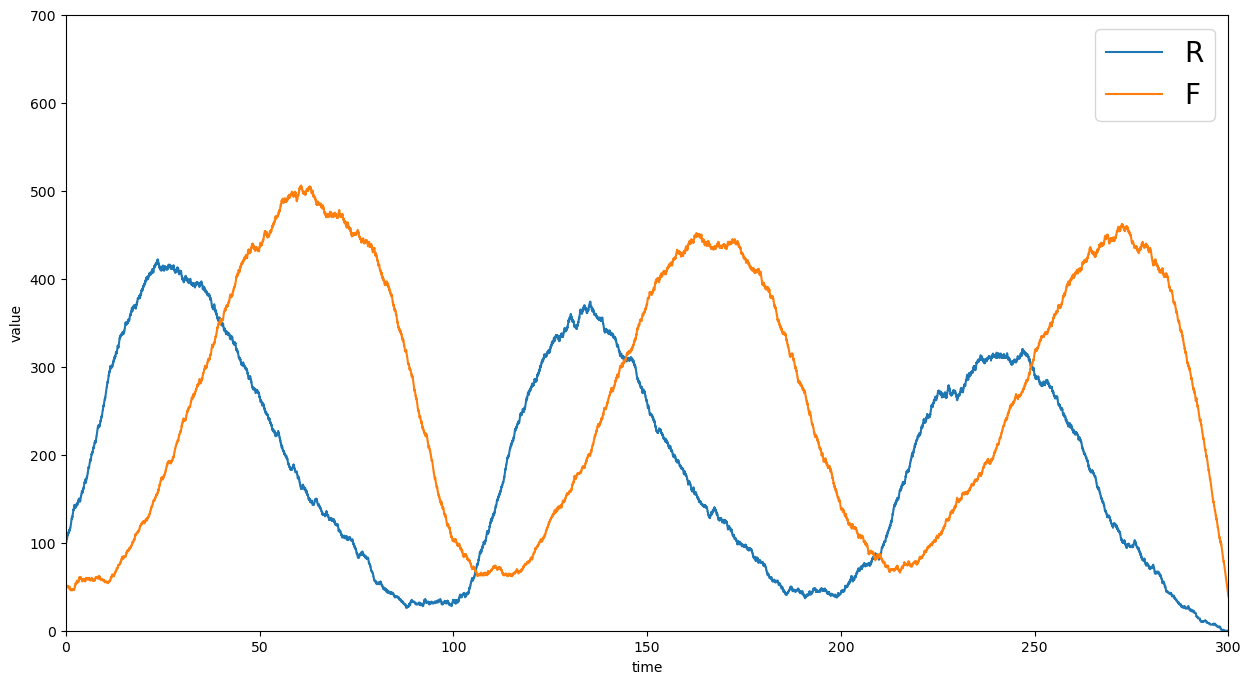

In [461]:
# np.random.seed(1)
# Stoichiometry matrix, R: first column, F: second column
N = np.array([[1, 0],  # R increase, F nothing 
              [-1,1],  # F increase, R decrease
              [0,-1]]) # F decrease, R nothing

a, b, c = 1, 0.005, 0.6
Y0 = np.array([[100.0, 50.0]]) # initial condition
Y = Y0.copy()
result = []
time = np.linspace(0, 300, 10001)

for t in time:
    result.append(Y.tolist())
    
    # prospensity vector
    P = np.array([[a * Y[0,0]],
                  [b * Y[0,0] * Y[0,1]],
                  [c * Y[0,1]]])
    # computing the probability vector by 
    # normalizing the prospendity vector
    p = P / (P.sum() + 1e-8) 
    
    # finding the desired state by using 
    # inverse transform sampling
    u = np.random.rand(1)
    for state, p_i in enumerate(np.cumsum(p)):
        if u < p_i:
            break
    # computing the index
    Y += N[state] 
    
plt.figure(figsize=[15, 8])
R, F = np.array(result).reshape(-1, 2).T
plt.plot(time, R, label="R"), plt.plot(time, F, label="F")
plt.xlim(0, time[-1]), plt.ylim(0, 700)
plt.xlabel("time"), plt.ylabel("value")
plt.legend(fontsize=20)
plt.show()